# Video Generation for Aerodactylus - Futter On

This notebook is used to generate video content for Flutter On using the tools provided in the `aeraudioviz` package.

In [1]:
from aeraudioviz.audio import Audio, AudioFeatures
from aeraudioviz.audio.feature_utils import add_random_noise_column, add_sine_wave_column, fade_in_between_times, fade_out_between_times, set_to_zero_between_times
from aeraudioviz.image import BaseImage, ImageModifiers
from aeraudioviz.video import VideoGenerator, ModifierMapping

## Load the Audio File

Here we create an instance of the `Audio` class based on the input audio file.

In [2]:
audio = Audio('Aerodactylus - Jetsam Dreams - 04 Flutter On.wav')

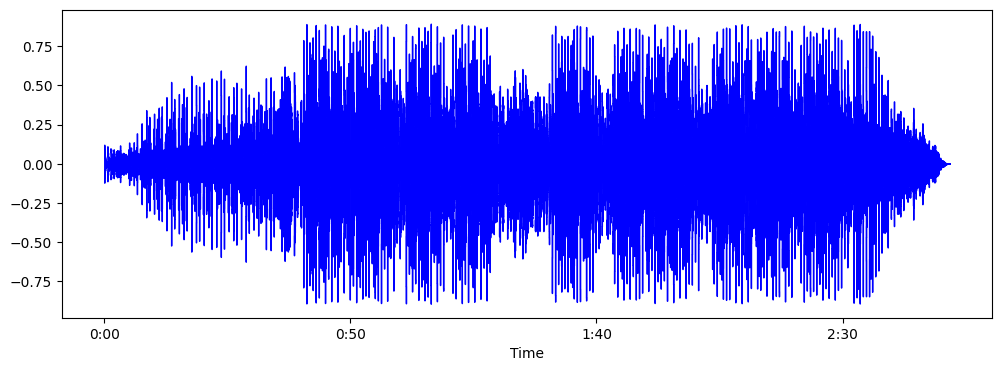

In [3]:
audio.plot_waveform()

## Extract Features from the Audio

Now we creat a `pandas.DataFrame` containing a time series of data features that will be used to manipulate the image in each frame of the video.

In [4]:
features = AudioFeatures(audio)

In [5]:
df = features.get_feature_time_series()

## Add Custom Features

Now we add some more custom features to the `DataFrame` that are not directly based on the audio data.

In [6]:
df = add_random_noise_column(df, column_name='Noise')

In [7]:
df['Spectral Centroid + Noise'] = df['Spectral Centroid'] + df['Noise'] * .1

In [8]:
bpm = 95.
df = add_sine_wave_column(df, frequency_Hz=0.1, column_name='LFO Slow')
df = add_sine_wave_column(df, frequency_Hz=bpm / 60., column_name='LFO Medium')
df = add_sine_wave_column(df, frequency_Hz=10., column_name='LFO Fast')
df = add_sine_wave_column(df, frequency_Hz=bpm / 60. / 4, column_name='LFO Sync')

In [9]:
df['Filtered Medium LFO'] = df['LFO Medium']
df.loc[df['Beats With Decay'].rolling(30).max().fillna(0.) < 0.1, 'Filtered Medium LFO'] = 0.
df['Filtered Medium LFO'] *= df['Noise']

In [10]:
df['LFO Slow + Noise'] = df['LFO Slow'] + df['Noise'] * .3

## Modify existing columns

We want some effects to only be present during certain parts of the track so we can fade in or out certain signals during specific sections, or set the signal 0.

In [11]:
df = set_to_zero_between_times(df, 'Filtered Medium LFO', 0., 40.125)
df = set_to_zero_between_times(df, 'Filtered Medium LFO', 81.125, 91.58333)

df = fade_in_between_times(df, 'Filtered Medium LFO', 40.125, 91.58333, factor=.8)
df = fade_out_between_times(df, 'Filtered Medium LFO', 160.4167, audio.duration)

df = set_to_zero_between_times(df, 'Spectral Centroid + Noise', 0., 40.125)
df = fade_in_between_times(df, 'Spectral Centroid + Noise', 40.125, 91.58333, factor=.8)

df = fade_out_between_times(df, 'Spectral Centroid', 160.4167, audio.duration)

df = fade_in_between_times(df, 'Onset', 0., 40.125, factor=.8)

## Plot the Time Series Features

These resulting features will be used to drive the dynamic effects in the video we generate later.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

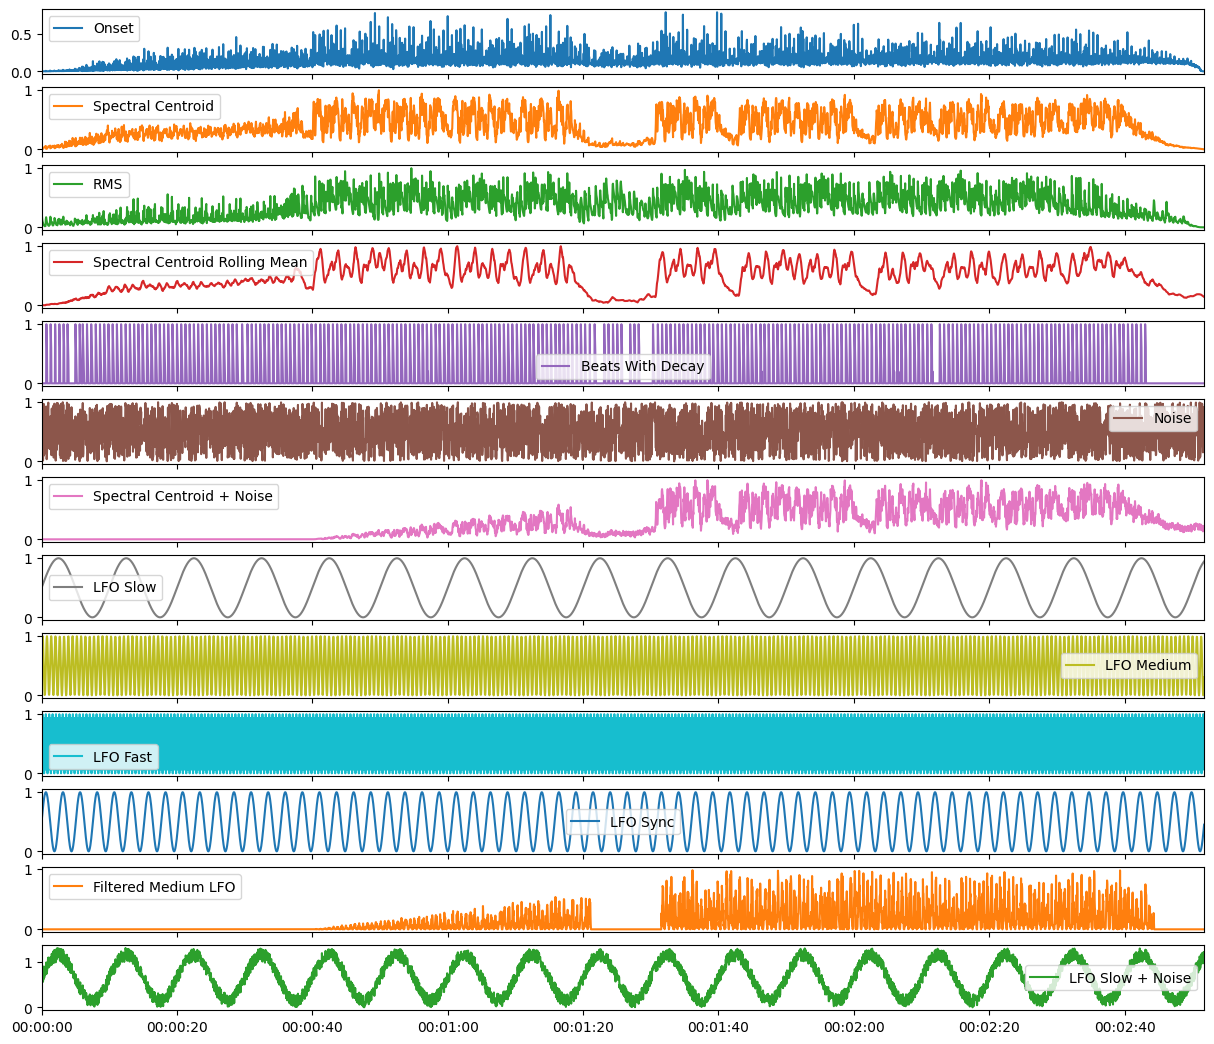

In [12]:
df.plot(subplots=True, figsize=(15, len(df.columns)))

## Load Base Image

The video will be generated by manipulating a base image based on the time series features generated previously. Here we load the base image.

In [13]:
image = BaseImage('cover.jpg')

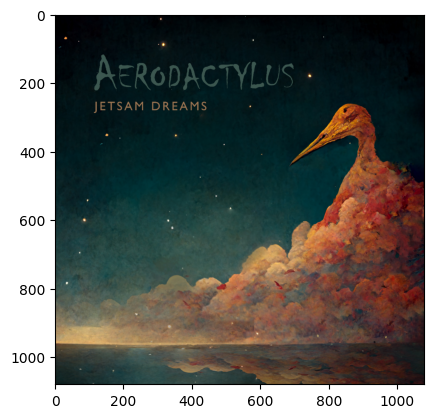

In [14]:
image.show()

## Define Mappings for Image Modification

We now define how the data columns in the time series features `DataFrame` are used to modify the image for each frame of the video.

Each `ModifierMapping` defines the following:
* `modifier_function`: the video effect function
* `modifier_column`: the data column from the time series `DataFrame` which is used to control the parameters of the `modifier_function` in each frame
* parameters: passed as `**kwargs` to the `ModifierMapping` class, key word argument name is the name of a parameter of the `modifier_function` and the value is a `tuple` defining the range of the values the function will take on at the min and max values of the data in the `modifier_column`.

In [15]:
modifier_mappings = (
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_green_vlines,
        modifier_column = 'Spectral Centroid + Noise',
        no_lines = (0, 8)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Spectral Centroid Rolling Mean',
        saturation_factor = (.5, 1.75)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_hue_multiplication,
        modifier_column = 'Filtered Medium LFO',
        hue_factor = (1., 2.)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_salt_and_pepper_noise,
        modifier_column = 'Spectral Centroid',
        noise_ratio = (0., .0013)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'LFO Slow',
        blue_factor = (1., 0.8),
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_red_scaling,
        modifier_column = 'LFO Slow + Noise',
        scale_factor = (.0, .1)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_green_scaling,
        modifier_column = 'LFO Slow + Noise',
        scale_factor = (.0, .025)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'Spectral Centroid Rolling Mean',
        green_factor = (1., 1.1)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'RMS',
        red_factor = (0.8, 1.3),
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_noise,
        modifier_column = 'Spectral Centroid',
        standard_deviation = (0., .5)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_ghost_images,
        modifier_column = 'Onset',
        number_of_ghost_images = (0, 10),
        alpha = (.1, .2)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Beats With Decay',
        saturation_factor = (1., 1.75)
    ),
    
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_blur,
        modifier_column = 'Beats With Decay',
        kernel_size = (0, 15)
    )
)

## Generate Video

Now that we have defined the audio, base image, feature time series data, and modifier mappings we can proceed to generate the video.

In [16]:
video = VideoGenerator(
    base_image=image, 
    feature_time_series=df, 
    modifier_mappings=modifier_mappings,
    audio=audio
)

In [17]:
output_file_name = audio.audio_path.split('.')[0] + '.mp4'
video.generate(output_file_name)

Generating video frames...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4123/4123 [19:38<00:00,  3.50it/s]


Frames generated.
Setting audio...
Audio set.
Writing video...
Moviepy - Building video Aerodactylus - Jetsam Dreams - 04 Flutter On.mp4.
MoviePy - Writing audio in Aerodactylus - Jetsam Dreams - 04 Flutter OnTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Aerodactylus - Jetsam Dreams - 04 Flutter On.mp4



Moviepy - Done !
Moviepy - video ready Aerodactylus - Jetsam Dreams - 04 Flutter On.mp4
Video written successfully to Aerodactylus - Jetsam Dreams - 04 Flutter On.mp4.
